In [9]:
!pip install spacy

    100% |████████████████████████████████| 30.8MB 1.7MB/s eta 0:00:011
    100% |████████████████████████████████| 92kB 46.0MB/s ta 0:00:01
    100% |████████████████████████████████| 3.2MB 22.3MB/s eta 0:00:01
    100% |████████████████████████████████| 184kB 57.6MB/s ta 0:00:01
    100% |████████████████████████████████| 2.1MB 26.7MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 29.7MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
!python -m spacy download en_core_web_lg
!python -m spacy link en_core_web_lg web_lg --force

    100% |████████████████████████████████| 826.9MB 49.4MB/s ta 0:00:011  2% |▉                               | 21.0MB 57.6MB/s eta 0:00:14    6% |██                              | 53.4MB 105.5MB/s eta 0:00:08    17% |█████▌                          | 143.0MB 65.5MB/s eta 0:00:11    25% |████████▏                       | 212.0MB 44.9MB/s eta 0:00:14    26% |████████▌                       | 219.0MB 2.4MB/s eta 0:04:12    31% |██████████                      | 257.0MB 23.6MB/s eta 0:00:25�█████████▍                    | 293.7MB 136.3MB/s eta 0:00:04    39% |████████████▌                   | 323.5MB 15.0MB/s eta 0:00:34    39% |████████████▊                   | 328.1MB 1.9MB/s eta 0:04:26    40% |████████████▉                   | 331.0MB 21.6MB/s eta 0:00:23█                  | 360.8MB 57.7MB/s eta 0:00:09█                  | 362.6MB 62.3MB/s eta 0:00:08█                  | 364.6MB 63.5MB/s eta 0:00:08��█████████████▉                 | 383.8MB 80.0MB/s eta 0:00:065MB 63.8MB/s eta 0:00:07

In [11]:
from math import sqrt
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import spacy

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/sub-stats/ds/master/4-30-to-7-29-submissions.csv', low_memory=False)

In [13]:
nlp = spacy.load('web_lg')

In [14]:
plt.rcParams['figure.figsize'] = [10, 10]

In [15]:
col_to_parse = 'title'
df2 = pd.DataFrame()
for sub in ['askscience', 'AskHistorians', 'AskComputerScience',
       'AskCulinary', 'AskSocialScience', 'AskEngineers', 'askphilosophy']:
    condition = df['subreddit'] == sub
    df2 = df2.append(df[condition][[col_to_parse, 'subreddit']].sample(150))

In [16]:
df['subreddit'].unique()

array(['AskReddit', 'askscience', 'AskHistorians', 'AskComputerScience',
       'AskCulinary', 'TrueAskReddit', 'AskSocialScience', 'AskEngineers',
       'askphilosophy'], dtype=object)

In [17]:
tokens = []
lemma = []
pos = []
parsed_doc = [] 

for doc in nlp.pipe(df2[col_to_parse].astype('unicode').values, batch_size=50,
                        n_threads=3):
    if doc.is_parsed:
        parsed_doc.append(doc)
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)


df2['parsed_doc'] = parsed_doc
df2['comment_tokens'] = tokens
df2['comment_lemma'] = lemma
df2['pos_pos'] = pos

In [18]:
df2.head()

,title,subreddit,parsed_doc,comment_tokens,comment_lemma,pos_pos
75176,"What is that condition that makes you ""see"" th...",askscience,"(What, is, that, condition, that, makes, you, ...","[What, is, that, condition, that, makes, you, ...","[what, be, that, condition, that, make, -PRON-...","[PRON, VERB, DET, NOUN, DET, VERB, PRON, PUNCT..."
27714,"How much ""slime"" does the most productive vari...",askscience,"(How, much, "", slime, "", does, the, most, prod...","[How, much, "", slime, "", does, the, most, prod...","[how, much, "", slime, "", do, the, most, produc...","[ADV, ADJ, PUNCT, NOUN, PUNCT, VERB, DET, ADV,..."
81978,When do we develop our conciousness?,askscience,"(When, do, we, develop, our, conciousness, ?)","[When, do, we, develop, our, conciousness, ?]","[when, do, -PRON-, develop, -PRON-, conciousne...","[ADV, VERB, PRON, VERB, DET, NOUN, PUNCT]"
72522,"How could the Boötes Void, an area of very lit...",askscience,"(How, could, the, Boötes, Void, ,, an, area, o...","[How, could, the, Boötes, Void, ,, an, area, o...","[how, could, the, Boötes, Void, ,, an, area, o...","[ADV, VERB, DET, PROPN, PROPN, PUNCT, DET, NOU..."
88656,How can you be the 'direct' descendant of some...,askscience,"(How, can, you, be, the, ', direct, ', descend...","[How, can, you, be, the, ', direct, ', descend...","[how, can, -PRON-, be, the, ', direct, ', desc...","[ADV, VERB, PRON, VERB, DET, PUNCT, ADJ, PUNCT..."


In [19]:
df2.shape

(1050, 6)

In [20]:
df2['subreddit'].value_counts()

AskSocialScience      150
AskHistorians         150
askphilosophy         150
AskEngineers          150
askscience            150
AskCulinary           150
AskComputerScience    150
Name: subreddit, dtype: int64

In [21]:
df3 = df2.copy()
df3 = df3.reset_index()

In [22]:
df3['parsed_doc'][0].similarity(df3['parsed_doc'][1])

0.8870620557450749

In [23]:
# Empty graph                            
raw_G = nx.Graph()
n = 0

# Iterate over every combination of two titles
for i_pos, i in enumerate(df3['parsed_doc']):
    for j in range(i_pos+1, len(df3['parsed_doc'])):
        # If mirrored edge not present, add edge
        if not (raw_G.has_edge(df3['parsed_doc'][j], i)):
            sim = i.similarity(df3['parsed_doc'][j])
            raw_G.add_edge(i, df3['parsed_doc'][j], weight = sim)
            n += 1

print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")

1050 nodes, and 550725 edges created.


In [24]:
edges_to_kill = []
min_wt = 0.93      # this is our cutoff value for a minimum edge-weight 

for n, nbrs in raw_G.adj.items():
    for nbr, eattr in nbrs.items():
        # remove edges below a certain weight
        data = eattr['weight']
        if data < min_wt:
            edges_to_kill.append((n, nbr)) 
            
print("\n", len(edges_to_kill) / 2, "edges to kill (of", raw_G.number_of_edges(), "), before de-duplicating")


 549772.0 edges to kill (of 550725 ), before de-duplicating


In [25]:
for u, v in edges_to_kill:
    if raw_G.has_edge(u, v):   # catches (e.g.) those edges where we've removed them using reverse ... (v, u)
        raw_G.remove_edge(u, v)

In [26]:
strong_G = raw_G
print(strong_G.number_of_edges())

953


In [27]:
title = df2['title'].to_list()
sub = df2['subreddit'].to_list()
sub_map = dict(zip(title, sub))

color_map = {'AskReddit':'black', 
             'askscience':'red', 
             'AskHistorians':'green', 
             'AskComputerScience':'blue',
             'AskCulinary':'yellow', 
             'TrueAskReddit':'orange', 
             'AskSocialScience':'purple', 
             'AskEngineers':'pink',
             'askphilosophy':'silver'}

color_list = []
for node in strong_G:
    color_list.append(color_map[sub_map[str(node)]])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



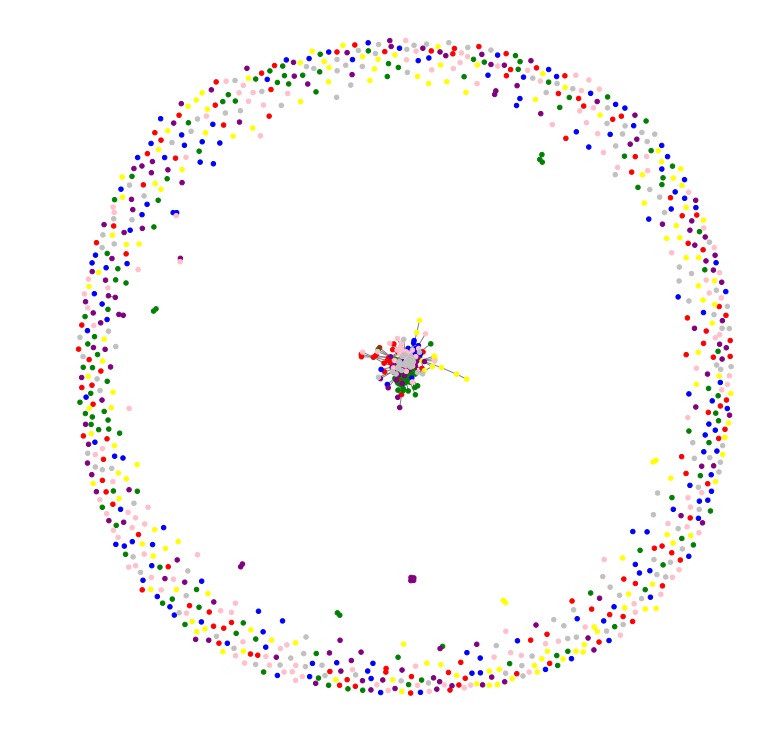

In [28]:
nx.draw(strong_G, node_size=20, edge_color='gray', node_color=color_list)

In [29]:
strong_G.remove_nodes_from(list(nx.isolates(strong_G)))

In [199]:
title = df2['title'].to_list()
sub = df2['subreddit'].to_list()
sub_map = dict(zip(title, sub))

color_map = {'askscience':'red', 
             'AskHistorians':'green', 
             'AskComputerScience':'blue',
             'AskCulinary':'yellow', 
             'AskSocialScience':'purple', 
             'AskEngineers':'pink',
             'askphilosophy':'black'}

color_list = []
for node in strong_G:
    color_list.append(color_map[sub_map[str(node)]])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



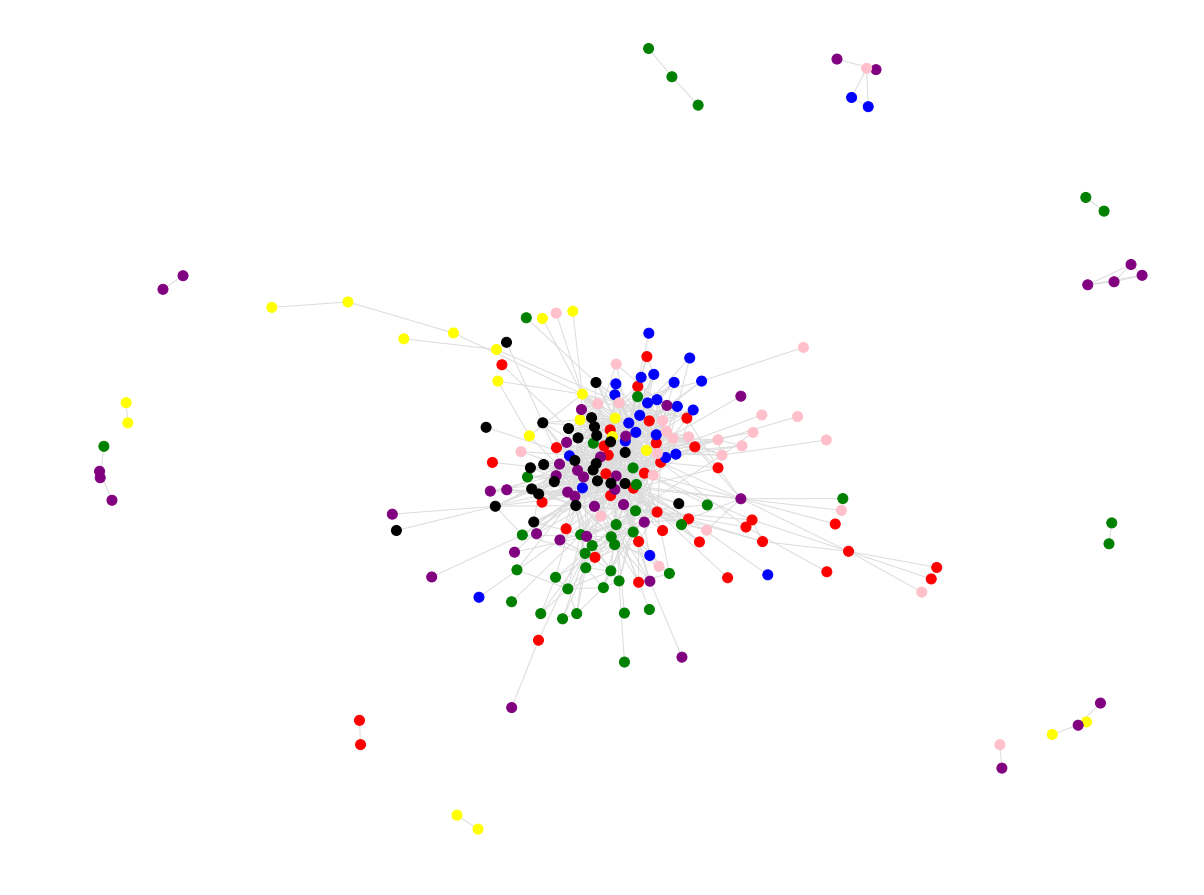

In [31]:
count = strong_G.number_of_nodes()
equilibrium = 10 / sqrt(count)    # default for this is 1/sqrt(n), but this will 'blow out' the layout for better visibility
plt.rcParams['figure.figsize'] = [16, 12]  # a better aspect ratio for labelled nodes
pos = nx.fruchterman_reingold_layout(strong_G, k=equilibrium, iterations=300)
nx.draw(strong_G, pos, node_size=100, edge_color='gainsboro', with_labels=False, node_color=color_list)

plt.show()

# Plotly Graph Port

In [182]:
import plotly as py
import numpy as np
from plotly.graph_objs import *

py.tools.set_credentials_file(username='urza1302', api_key='THxYDZQG6P3mtcXBecIZ')

In [183]:
pos = nx.fruchterman_reingold_layout(strong_G)
E = [e for e in strong_G.edges.data()]

In [200]:
Xv=[pos[key][0] for key in pos]
Yv=[pos[key][1] for key in pos]
Xed=[]
Yed=[]
for edge in E:
    Xed+=[pos[edge[0]][0], pos[edge[1]][0], None]
    Yed+=[pos[edge[0]][1], pos[edge[1]][1], None]

trace1=Scatter(x=Xed,
               y=Yed,
               mode='lines',
               line=dict(color='rgb(210,210,210)', width=1),
               hoverinfo='skip',
               showlegend=False
               )

trace2=Scatter(x=Xv,
               y=Yv,
               mode='markers',
               marker=dict(symbol='circle-dot',
                             size=10,
                             color=color_list,
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               hoverinfo='skip',
               showlegend=False
               )

AskScience=Scatter(x=None,
                   y=None,
                   name='AskScience',
                   mode='markers',
                   marker=dict(symbol='circle-dot',
                                 size=10,
                                 color='red'),
                   hoverinfo='skip'
                   )

# Create a custom legend
data = [trace1, trace2]
for key in color_map:
    trace = Scatter(x=None,
                    y=None,
                    name=key,
                    mode='markers',
                    marker=dict(symbol='circle-dot',
                                size=10,
                                color=color_map[key]),
                    hoverinfo='skip')
    data.append(trace)

In [201]:
fig1=Figure(data=data)
py.plotly.iplot(fig1, filename='subreddit-posts-thematic-analysis-nx')

In [2]:
import json
from plotly.utils import PlotlyJSONEncoder
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

def plotlyfig2json(fig, fpath=None):
    """
    Serialize a plotly figure object to JSON so it can be persisted to disk.
    Figure's persisted as JSON can be rebuilt using the plotly JSON chart API:

    http://help.plot.ly/json-chart-schema/

    If `fpath` is provided, JSON is written to file.

    Modified from https://github.com/nteract/nteract/issues/1229
    """

    redata = json.loads(json.dumps(fig.data, cls=PlotlyJSONEncoder))
    relayout = json.loads(json.dumps(fig.layout, cls=PlotlyJSONEncoder))

    fig_json=json.dumps({'data': redata})

    if fpath:
        with open(fpath, 'w') as f:
            f.write(fig_json)
    else:
        return fig_json

def plotlyfromjson(fpath):
    """Render a plotly figure from a json file"""
    with open(fpath, 'r') as f:
        v = json.loads(f.read())

    return v['data']

In [202]:
plotlyfig2json(fig1, 'network_graph.json')

In [203]:
fig = plotlyfromjson('network_graph.json')

In [204]:
py.plotly.iplot(fig, filename='subreddit-posts-thematic-analysis-nx')

In [2]:
import pandas as pd

In [3]:
df = pd.read_json('https://raw.githubusercontent.com/sub-stats/ds/master/network_graph.json')

In [12]:
df.loc[5].to_dict()

{'data': {'type': 'scatter',
  'x': None,
  'y': None,
  'name': 'AskCulinary',
  'mode': 'markers',
  'marker': {'symbol': 'circle-dot', 'size': 10, 'color': 'yellow'},
  'hoverinfo': 'skip'}}